In [1]:
import keras
from keras.layers import *
from keras.preprocessing import *
from keras.optimizers import *
from keras.constraints import unit_norm
import numpy as np
import pandas as pd
import os

from csv import DictReader
import csv

from sklearn.metrics import *
from data_frame import DataFrame

from RocAucEvaluation import RocAucEvaluation

from sklearn.base import BaseEstimator
from sklearn import preprocessing
from keras.models import Model
from keras.regularizers import l2 as l2_reg
import itertools

import csv

import tensorflow as tf

/home/mohsin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# dtypes = {
#         'ip'            : 'uint32',
#         'app'           : 'uint16',
#         'device'        : 'uint16',
#         'os'            : 'uint16',
#         'channel'       : 'uint16',
#         'is_attributed' : 'uint8',
#         'click_id'      : 'uint32',
#         'hourofday'     : 'uint8',
#         'dayofweek'     : 'uint8',
#         'ip_device_os'     : 'uint32',
#         'ip_device_os_app'     : 'uint32',
#         'ip_device_os_app_channel' : 'uint32',
#         }
# df = pd.read_csv('../input/train.csv', usecols=['ip', 'app', 'device', 'os', 'channel', 'is_attributed'], 
#                  dtype = dtypes)

# print(df.ip.values.shape)
# np.save('../input/ip.npy', df.ip.values)
# np.save('../input/app.npy', df.app.values)
# np.save('../input/device.npy', df.device.values)
# np.save('../input/os.npy', df.os.values)
# np.save('../input/channel.npy', df.channel.values)
# np.save('../input/is_attributed.npy', df.is_attributed.values)
# del df

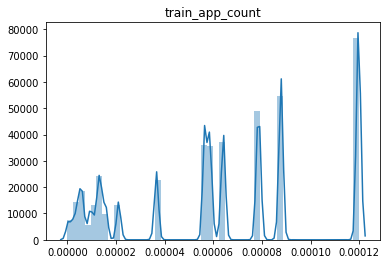

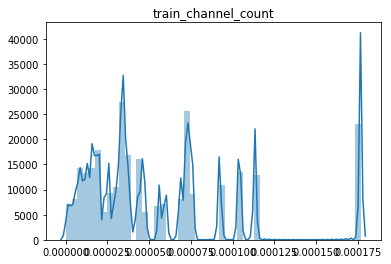

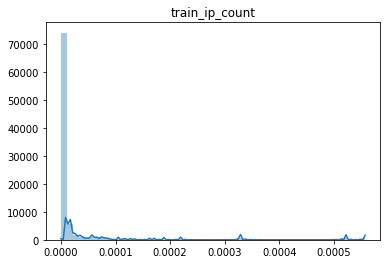

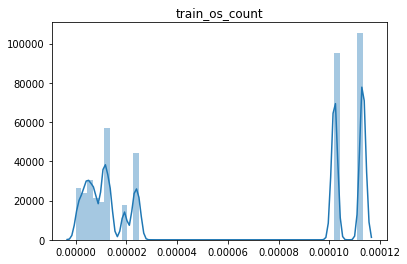

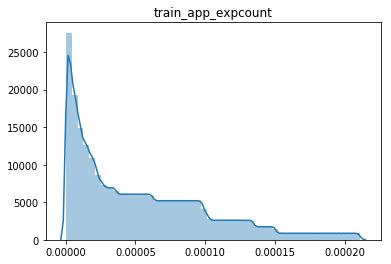

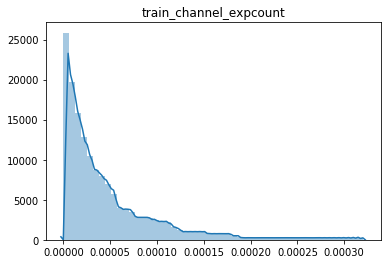

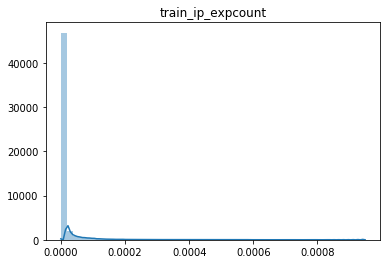

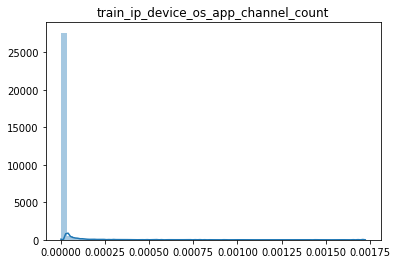

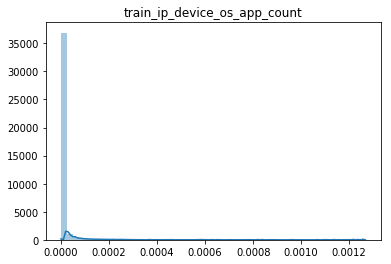

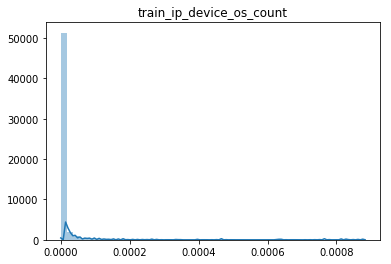

In [7]:
# Normalization of counts
# import seaborn as sns
# import matplotlib.pyplot as plt


# output_dir = "../output/"
# count_cols = [
#     'train_app_count',
#     'train_channel_count',
#     'train_ip_count',
#     'train_os_count',
#     'train_app_expcount',
#     'train_channel_expcount',
#     'train_ip_expcount',
#     'train_ip_device_os_app_channel_count',
#     'train_ip_device_os_app_count',
#     'train_ip_device_os_count'
# #     'train_ip_device_os_app_channel_next_click_1',
# #     'train_ip_device_os_app_channel_next_click_2',
# #     'train_ip_device_os_app_channel_prev_click_1',
# #     'train_ip_device_os_app_channel_prev_click_2',
# #     'train_ip_device_os_app_next_click_1',
# #     'train_ip_device_os_app_next_click_2',
# #     'train_ip_device_os_app_prev_click_1'
# ]
# for i in count_cols:
#     count_data = np.load(os.path.join(output_dir, '{}.npy'.format(i)))
#     normalized_data = preprocessing.normalize(count_data.reshape(1,-1), norm = 'l2')
#     plt.figure()
#     sns.distplot(normalized_data.ravel())
#     plt.title(i)
#     plt.show()
#     np.save(os.path.join(output_dir, '{}_normalized.npy'.format(i)), normalized_data.ravel())

In [ ]:
data_cols = [
    'ip',
    'app',
    'device',
    'os',
    'channel',
    'is_attributed'
]
data_dir = "../input/"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i)), mmap_mode='r') for i in data_cols]

output_dir = "../output/"
count_cols = [
#     'app_count_normalized',
#     'channel_count_normalized',
#     'ip_count_normalized',
#     'os_count_normalized',
#     'app_expcount_normalized',
#     'channel_expcount_normalized',
#     'ip_expcount_normalized',
    'ip_device_os_app_channel_count_normalized',
    'ip_device_os_app_count_normalized',
    'ip_device_os_count_normalized',
    'ip_device_os_app_channel_next_click_1',
#    'ip_device_os_app_channel_next_click_2',
    'ip_device_os_app_channel_prev_click_1',
#    'ip_device_os_app_channel_prev_click_2',
    'ip_device_os_app_next_click_1',
#    'ip_device_os_app_next_click_2',
    'ip_device_os_app_prev_click_1',
#    'ip_device_os_app_prev_click_2',
    'ip_device_os_next_click_1',
#    'ip_device_os_next_click_2',
    'ip_device_os_prev_click_1',
#    'ip_device_os_prev_click_2',
    'ip_next_click_1',
#    'ip_next_click_2',
    'ip_prev_click_1'
#    'ip_prev_click_2'
]
count_data = [np.load(os.path.join(output_dir, 'train_{}.npy'.format(i)), mmap_mode='r') for i in count_cols]

data_df = DataFrame(columns=data_cols+count_cols, data=data+count_data)

train_df, val_df = data_df.train_test_split(train_size=0.9)

print(train_df.shapes(), 'train data')
print(val_df.shapes(), 'validation data')
print(data_df.shapes(), 'data')

def train_batch_generator(batch_size, train_df):
    return batch_generator(
        batch_size=batch_size,
        df=train_df,
        shuffle=True,
        num_epochs=10000,
        is_test=False
    )
def val_batch_generator(batch_size, val_df):
    return batch_generator(
        batch_size=batch_size,
        df=val_df,
        shuffle=True,
        num_epochs=10000,
        is_test=False
    )

def test_batch_generator(batch_size, test_df):
    return batch_generator(
        batch_size=batch_size,
        df=test_df,
        shuffle=False,
        num_epochs=1,
        is_test=True
    )

def batch_generator(batch_size, df, shuffle=True, num_epochs=10000, is_test=False):
    batch_gen = df.batch_generator(batch_size, shuffle=shuffle, num_epochs=num_epochs, allow_smaller_final_batch=is_test)
    for batch in batch_gen:
        batch['ip'] = batch['ip']
        batch['app'] = batch['app']
        batch['device'] = batch['device']
        batch['os'] = batch['os']
        batch['channel'] = batch['channel']
#         batch['app_count_normalized'] = batch['app_count_normalized']
#         batch['channel_count_normalized'] = batch['channel_count_normalized']
#         batch['ip_count_normalized'] = batch['ip_count_normalized']
#         batch['os_count_normalized'] = batch['os_count_normalized']
#         batch['app_expcount_normalized'] = batch['app_expcount_normalized']
#         batch['channel_expcount_normalized'] = batch['channel_expcount_normalized']
#         batch['ip_expcount_normalized'] = batch['ip_expcount_normalized']
        batch['ip_device_os_app_channel_count_normalized'] = batch['ip_device_os_app_channel_count_normalized']
        batch['ip_device_os_app_count_normalized'] = batch['ip_device_os_app_count_normalized']
        batch['ip_device_os_count_normalized'] = batch['ip_device_os_count_normalized']
        batch['ip_device_os_app_channel_next_click_1'] = batch['ip_device_os_app_channel_next_click_1']
#        batch['ip_device_os_app_channel_next_click_2'] = batch['ip_device_os_app_channel_next_click_2']
        batch['ip_device_os_app_channel_prev_click_1'] = batch['ip_device_os_app_channel_prev_click_1']
#        batch['ip_device_os_app_channel_prev_click_2'] = batch['ip_device_os_app_channel_prev_click_2']
        batch['ip_device_os_app_next_click_1'] = batch['ip_device_os_app_next_click_1']
#        batch['ip_device_os_app_next_click_2'] = batch['ip_device_os_app_next_click_2']
        batch['ip_device_os_app_prev_click_1'] = batch['ip_device_os_app_prev_click_1']
#        batch['ip_device_os_app_prev_click_2'] = batch['ip_device_os_app_prev_click_2']
        batch['ip_device_os_next_click_1'] = batch['ip_device_os_next_click_1']
#        batch['ip_device_os_next_click_2'] = batch['ip_device_os_next_click_2']
        batch['ip_device_os_prev_click_1'] = batch['ip_device_os_prev_click_1']
#        batch['ip_device_os_prev_click_2'] = batch['ip_device_os_prev_click_2']
        batch['ip_next_click_1'] = batch['ip_next_click_1']
#        batch['ip_next_click_2'] = batch['ip_next_click_2']
        batch['ip_next_prev_1'] = batch['ip_next_prev_1']
#        batch['ip_next_prev_2'] = batch['ip_next_prev_2']
        if not is_test:
            batch['is_attributed'] = batch['is_attributed']
            yield [batch['ip'], batch['app'], batch['device'], batch['os'], batch['channel'],
#                   batch['app_count_normalized'],
#                     batch['channel_count_normalized'],
#                     batch['ip_count_normalized'],
#                     batch['os_count_normalized'],
#                     batch['app_expcount_normalized'],
#                     batch['channel_expcount_normalized'],
#                     batch['ip_expcount_normalized'],
                    batch['ip_device_os_app_channel_count_normalized'],
                    batch['ip_device_os_app_count_normalized'],
                    batch['ip_device_os_count_normalized'],
                    batch['ip_device_os_app_channel_next_click_1'],
#                    batch['ip_device_os_app_channel_next_click_2'],
                    batch['ip_device_os_app_channel_prev_click_1'],
#                    batch['ip_device_os_app_channel_prev_click_2'],
                    batch['ip_device_os_app_next_click_1'],
#                    batch['ip_device_os_app_next_click_2'],
                    batch['ip_device_os_app_prev_click_1'],
#                    batch['ip_device_os_app_prev_click_2'],
                    batch['ip_device_os_next_click_1'],
#                    batch['ip_device_os_next_click_2'],
                    batch['ip_device_os_prev_click_1'],
#                    batch['ip_device_os_prev_click_2'],
                    batch['ip_next_click_1'],
#                    batch['ip_next_click_2'],
                    batch['ip_prev_click_1']
#                    batch['ip_prev_click_2']
                  ], batch['is_attributed']
        else:
            yield [batch['ip'], batch['app'], batch['device'], batch['os'], batch['channel'],
#                   batch['app_count_normalized'],
#                     batch['channel_count_normalized'],
#                     batch['ip_count_normalized'],
#                     batch['os_count_normalized'],
#                     batch['app_expcount_normalized'],
#                     batch['channel_expcount_normalized'],
#                     batch['ip_expcount_normalized'],
                    batch['ip_device_os_app_channel_count_normalized'],
                    batch['ip_device_os_app_count_normalized'],
                    batch['ip_device_os_count_normalized'],
                    batch['ip_device_os_app_channel_next_click_1'],
#                    batch['ip_device_os_app_channel_next_click_2'],
                    batch['ip_device_os_app_channel_prev_click_1'],
#                    batch['ip_device_os_app_channel_prev_click_2'],
                    batch['ip_device_os_app_next_click_1'],
#                    batch['ip_device_os_app_next_click_2'],
                    batch['ip_device_os_app_prev_click_1'],
 #                   batch['ip_device_os_app_prev_click_2'],
                    batch['ip_device_os_next_click_1'],
  #                  batch['ip_device_os_next_click_2'],
                    batch['ip_device_os_prev_click_1'],
   #                 batch['ip_device_os_prev_click_2'],
                    batch['ip_next_click_1'],
    #                batch['ip_next_click_2'],
                    batch['ip_prev_click_1']
     #               batch['ip_prev_click_2']
                  ]

/home/mohsin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [4]:
# def gen(input_file_name,batchsz = 10000):
#     input_csvfile = open(input_file_name)
#     input_reader = csv.reader(input_csvfile)
#     cols = next(input_reader)

#     batchCount = 0
#     ips = []
#     apps = []
#     devices = []
#     oss = []
#     channels = []
#     targets = []
#     while True:
#         try:
#             input_line = next(input_reader)
#         except:
#             input_csvfile.seek(0)
#             cols = next(input_reader)
#             input_line = next(input_reader)
            
#         ips.append(input_line[0])
#         apps.append(input_line[1])
#         devices.append(input_line[2])
#         oss.append(input_line[3])
#         channels.append(input_line[4])
#         targets.append(input_line[-1])
#         batchCount += 1
#         if batchCount >= batchsz:
#             batchCount = 0
# #             X = {}
# #             X['ip'] = np.array(ips)
# #             X['app'] = np.array(apps)
# #             X['device'] = np.array(devices)
# #             X['os'] = np.array(oss)
# #             X['channel'] = np.array(channels)
#             X = [np.array(ips), np.array(apps), np.array(devices), np.array(oss), np.array(channels)]
#             y = np.array(targets)
#             ips = []
#             apps = []
#             devices = []
#             oss = []
#             channels = []
#             targets = []
#             yield X, y

In [ ]:
MAX_IP = 364779
MAX_APP = 769
MAX_DEVICE = 4227
MAX_OS = 956
MAX_CHANNEL = 500
NUM_LAYERS = 1

ip = Input(shape=(1,))
ip_embed = Embedding(MAX_IP, 40)(ip)

app = Input(shape=(1,))
app_embed = Embedding(MAX_APP, 6)(app)

device = Input(shape=(1,))
device_embed = Embedding(MAX_DEVICE, 6)(device)

os_layer = Input(shape=(1,))
os_embed = Embedding(MAX_OS, 6)(os_layer)

channel = Input(shape=(1,))
channel_embed = Embedding(MAX_CHANNEL, 6)(channel)

raw_inputs = [ip, app, device, os_layer, channel]

ip_embed2 = Embedding(MAX_IP, 6)(ip)

## Count layers
app_count_normalized = Input(shape=(1, ))
channel_count_normalized = Input(shape = (1, ))
ip_count_normalized = Input(shape = (1, ))
os_count_normalized = Input(shape = (1, ))

count_inputs = [app_count_normalized, 
                channel_count_normalized, 
                ip_count_normalized, 
                os_count_normalized]

## cummulative count layers
app_expcount_normalized = Input(shape=(1, ))
channel_expcount_normalized = Input(shape = (1, ))
ip_expcount_normalized = Input(shape = (1, ))
#os_expcount_normalized = Input(shape = (1, ))

cum_count_inputs = [app_expcount_normalized, 
                    channel_expcount_normalized, 
                    ip_expcount_normalized]

## combination count layers
ip_device_os_app_channel_count_normalized = Input(shape = (1, ))
ip_device_os_app_count_normalized = Input(shape = (1, ))
ip_device_os_count_normalized = Input(shape = (1, ))

comb_count_inputs = [ip_device_os_app_channel_count_normalized, 
                     ip_device_os_app_count_normalized, 
                     ip_device_os_count_normalized]

## next click layers
ip_device_os_app_channel_next_click_1 = Input(shape = (1, ))
#ip_device_os_app_channel_next_click_2 = Input(shape = (1, ))
ip_device_os_app_channel_prev_click_1 = Input(shape = (1, ))
#ip_device_os_app_channel_prev_click_2 = Input(shape = (1, ))
ip_device_os_app_next_click_1 = Input(shape = (1, ))
#ip_device_os_app_next_click_2 = Input(shape = (1, ))
ip_device_os_app_prev_click_1 = Input(shape = (1, ))
#ip_device_os_app_prev_click_2 = Input(shape = (1, ))
ip_device_os_next_click_1 = Input(shape = (1, ))
#ip_device_os_next_click_2 = Input(shape = (1, ))
ip_device_os_prev_click_1 = Input(shape = (1, ))
#ip_device_os_prev_click_2 = Input(shape = (1, ))
ip_next_click_1 = Input(shape = (1, ))
#ip_next_click_2 = Input(shape = (1, ))
ip_prev_click_1 = Input(shape = (1, ))
#ip_prev_click_2 = Input(shape = (1, ))

next_click_inputs = [
    ip_device_os_app_channel_next_click_1,
#    ip_device_os_app_channel_next_click_2,
    ip_device_os_app_channel_prev_click_1,
#    ip_device_os_app_channel_prev_click_2,
    ip_device_os_app_next_click_1,
#    ip_device_os_app_next_click_2,
    ip_device_os_app_prev_click_1,
#    ip_device_os_app_prev_click_2,
    ip_device_os_next_click_1,
#    ip_device_os_next_click_2,
    ip_device_os_prev_click_1,
#    ip_device_os_prev_click_2,
    ip_next_click_1,
#    ip_next_click_2,
    ip_prev_click_1
#    ip_prev_click_2
]


#device_embed2 = Embedding(MAX_DEVICE, 6, embeddings_constraint = unit_norm())(device)


ip_app_embed = Dot(2)([ip_embed2, app_embed])
ip_os_embed = Dot(2)([ip_embed2, os_embed])
ip_channel_embed = Dot(2)([ip_embed2, channel_embed])
#ip_device_embed = Dot(2)([ip_embed2, device_embed2])
app_os_embed = Dot(2)([app_embed, os_embed])
app_channel_embed = Dot(2)([app_embed, channel_embed])
#app_device_embed = Dot(2)([app_embed, device_embed2])
#os_device_embed = Dot(2)([os_embed, device_embed2])
os_channel_embed = Dot(2)([os_embed, channel_embed])
#device_channel_embed = Dot(2)([device_embed2, channel_embed])

x = concatenate([Flatten()(ip_embed),
                Flatten()(ip_embed2),
                Flatten()(app_embed), 
                 Flatten()(device_embed),
                 Flatten()(os_embed), 
                 Flatten()(channel_embed),
                 Flatten()(ip_app_embed),
                 Flatten()(ip_os_embed),
                 Flatten()(ip_channel_embed),
                 Flatten()(app_os_embed),
                 Flatten()(app_channel_embed),
                 Flatten()(os_channel_embed),
                app_count_normalized, 
                channel_count_normalized, 
                ip_count_normalized, 
                os_count_normalized,
                app_expcount_normalized, 
                channel_expcount_normalized, 
               ip_expcount_normalized,
                ip_device_os_app_channel_count_normalized, 
                ip_device_os_app_count_normalized, 
                ip_device_os_count_normalized,
                ip_device_os_app_channel_next_click_1,
     #           ip_device_os_app_channel_next_click_2,
                ip_device_os_app_channel_prev_click_1,
    #            ip_device_os_app_channel_prev_click_2,
                ip_device_os_app_next_click_1,
   #             ip_device_os_app_next_click_2,
                ip_device_os_app_prev_click_1,
  #              ip_device_os_app_prev_click_2,
                ip_device_os_next_click_1,
 #               ip_device_os_next_click_2,
                ip_device_os_prev_click_1,
#                ip_device_os_prev_click_2,
                ip_next_click_1,
#                ip_next_click_2,
                ip_prev_click_1])
#                ip_prev_click_2])


#x = BatchNormalization()(x)

for i in range(NUM_LAYERS+1):
    #x = BatchNormalization()(x)
    if i == 0:
        x = Dropout(0.6)(x)
        x = Dense(40, kernel_initializer='he_normal', kernel_constraint=unit_norm())(x)
        x = PReLU()(x)
    if i == 1:
        x = Dropout(0.5)(x)
        x = Dense(20, kernel_initializer='he_normal')(x)
        x = PReLU()(x)

#x = Dropout(0.1)(x)  
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs= raw_inputs + count_inputs + cum_count_inputs + comb_count_inputs + next_click_inputs, 
              outputs=out)
#embed_model = Model(inputs = [ip, app, device, os_layer, channel], outputs = [ip_embed, app_embed, device_embed, os_embed, channel_embed])

#adam = TFOptimizer(tf.train.FtrlOptimizer(0.02))
adam = Adam(lr=0.001, decay=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy')

In [ ]:
print(model.summary())

X_val = [val_df['ip'], val_df['app'], val_df['device'], val_df['os'], val_df['channel']]
y_val = val_df['is_attributed']
roc_auc = RocAucEvaluation(validation_data=(X_val, y_val))

model.fit_generator(train_batch_generator(100000, train_df),
        steps_per_epoch=400, epochs=10, 
                     validation_data=(X_val, y_val), callbacks=[roc_auc])
#                     validation_data = val_batch_generator(batch_size=100000, val_df = val_df),
#                    validation_steps = 10)

* BatchNormalization --> overfit early
* Device interaction not much useful